In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import warnings

warnings.simplefilter("ignore")
np.seed = 42

# Load Dataset

In [17]:
df = pd.read_csv(f'Final_Data/dataset.csv')
df.head(3)

,surface,best_of,Round,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_matches,...,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_matches,log_rank_difference,Choosen Player,T,Y
0,Clay,5,6,Raul Ramirez,R,183.0,MEX,20.3,32.0,5,...,R,183.0,AUS,29.4,2.0,5,4.000000,winner,0,1
1,Clay,3,5,John Newcombe,R,183.0,AUS,29.4,2.0,5,...,L,173.0,AUS,35.2,10.0,4,-2.321928,winner,1,1
2,Clay,3,4,Raul Ramirez,R,183.0,MEX,20.3,32.0,5,...,R,183.0,ROU,27.2,1.0,3,5.000000,winner,1,0


# Correlations

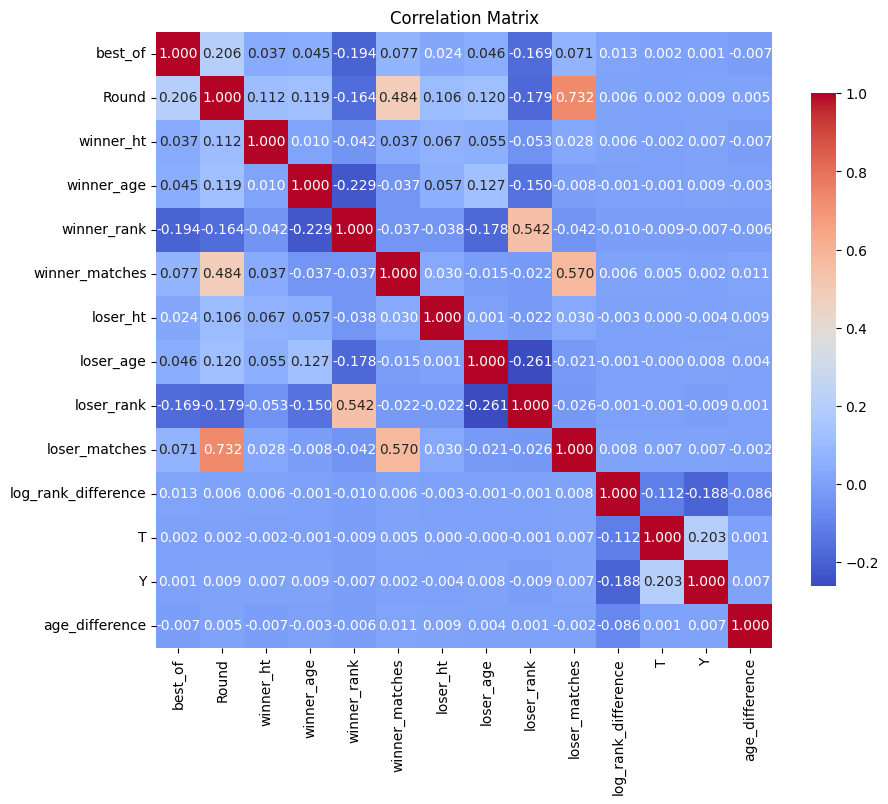

In [33]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
# numeric_df['winner_rank_bigger'] = (numeric_df['winner_rank'] < numeric_df['loser_rank']).astype(int)
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

# Age

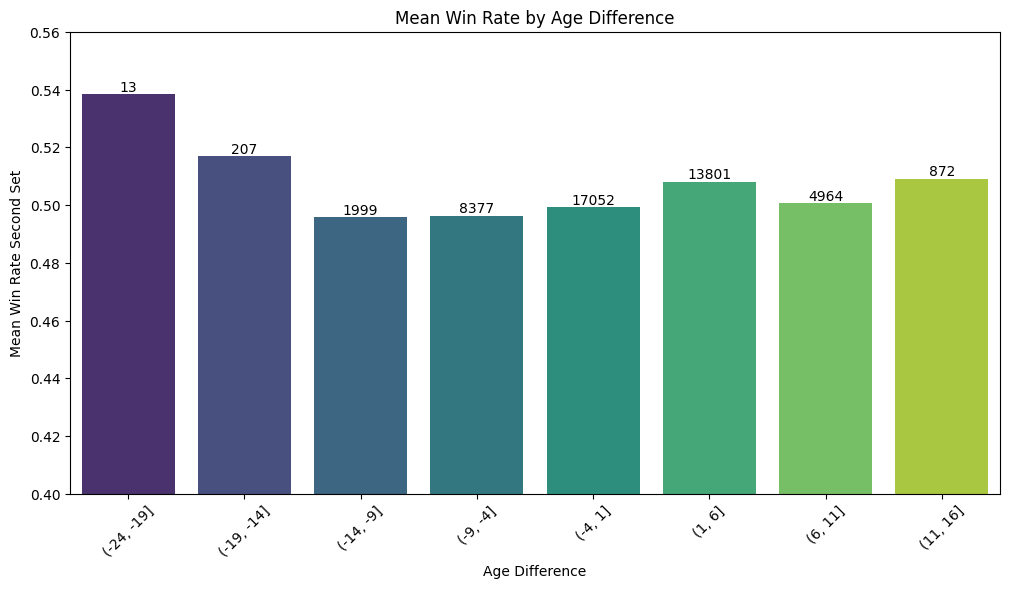

In [40]:
# Calculate age difference
df['age_difference'] = df.apply(lambda row: ((row['winner_age']) - (row['loser_age'])) 
                                            if row['Choosen Player']== 'winner' 
                                            else ((row['loser_age']) - (row['winner_age'])), axis=1)

# Bin the age differences
bins = range(int(df['age_difference'].min()), int(df['age_difference'].max()), 5)  # Bins of 5 years
df['age_diff_bin'] = pd.cut(df['age_difference'], bins)

# Calculate mean win rates and counts for each bin
mean_win_rate_by_age_diff = df.groupby('age_diff_bin')['Y'].mean().reset_index()
count_by_age_diff = df['age_diff_bin'].value_counts().reset_index(name='Count')

# Merge mean win rates with counts
mean_win_rate_by_age_diff = mean_win_rate_by_age_diff.merge(count_by_age_diff, on='age_diff_bin')
mean_win_rate_by_age_diff = mean_win_rate_by_age_diff.dropna()

# Create a bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=mean_win_rate_by_age_diff, x='age_diff_bin', y='Y', palette='viridis')

# Title and labels
plt.title('Mean Win Rate by Age Difference')
plt.xlabel('Age Difference')
plt.ylabel('Mean Win Rate Second Set')

# Improve x-ticks for readability
plt.xticks(rotation=45, ha='center')
plt.ylim(0, 1)

# Annotate bars with counts
for index, p in enumerate(bar_plot.patches):
    count = mean_win_rate_by_age_diff['Count'].iloc[index]
    bar_plot.annotate(f'{count}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', color='black', fontsize=10)

plt.ylim(0.4,0.56)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


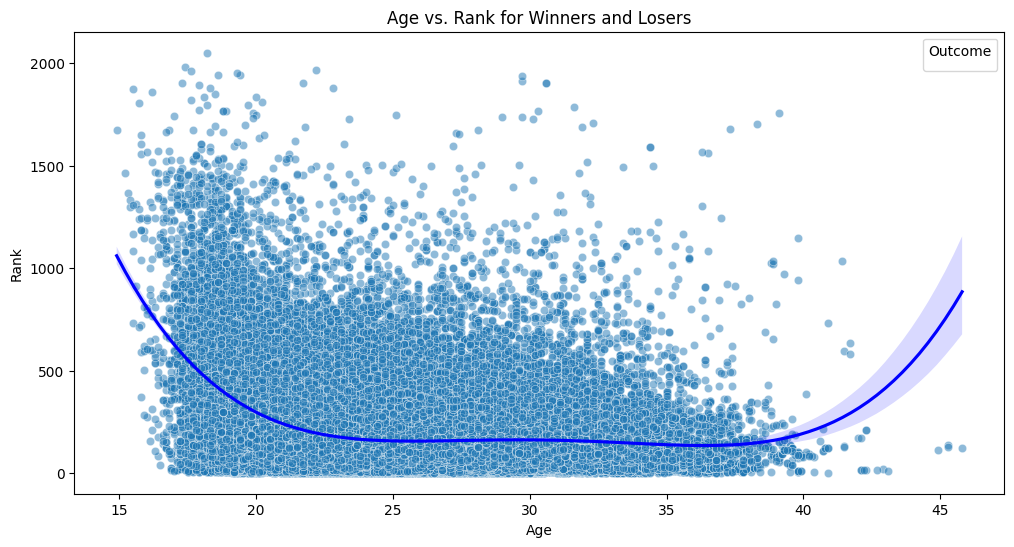

In [5]:
# Create a new DataFrame for winners
winners = df[['winner_age', 'winner_rank']].copy()
winners['Outcome'] = 'Winner'

# Create a new DataFrame for losers
losers = df[['loser_age', 'loser_rank']].copy()
losers.rename(columns={'loser_age': 'age', 'loser_rank': 'rank'}, inplace=True)
losers['Outcome'] = 'Loser'

# Combine the two DataFrames
combined_df = pd.concat([winners.rename(columns={'winner_age': 'age', 'winner_rank': 'rank'}), losers])

# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=combined_df, x='age', y='rank', alpha=0.5)

# Add regression lines for winners and losers
sns.regplot(data=combined_df, x='age', y='rank', color='blue', scatter=False, ci=95, order=4)

# Title and labels
plt.title('Age vs. Rank for Winners and Losers')
plt.xlabel('Age')
plt.ylabel('Rank')

# Show legend
plt.legend(title='Outcome')

# Show the plot
plt.show()

# Court

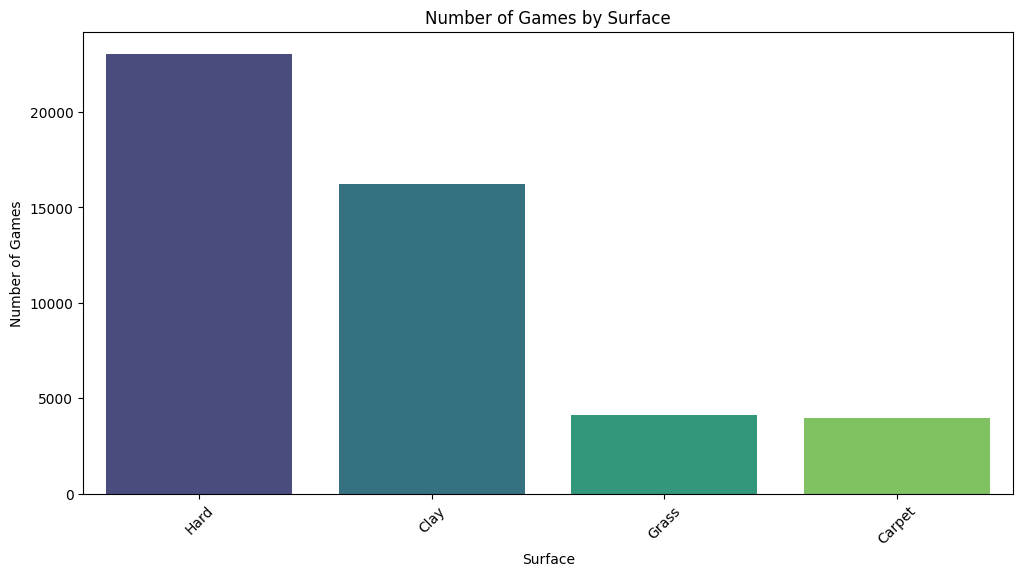

In [6]:
surface_counts = df['surface'].value_counts().reset_index()
surface_counts.columns = ['Surface', 'Count']

# Create a bar plot for surface counts
plt.figure(figsize=(12, 6))
sns.barplot(data=surface_counts, x='Surface', y='Count', palette='viridis')

# Title and labels
plt.title('Number of Games by Surface')
plt.xlabel('Surface')
plt.ylabel('Number of Games')

# Rotate x labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()


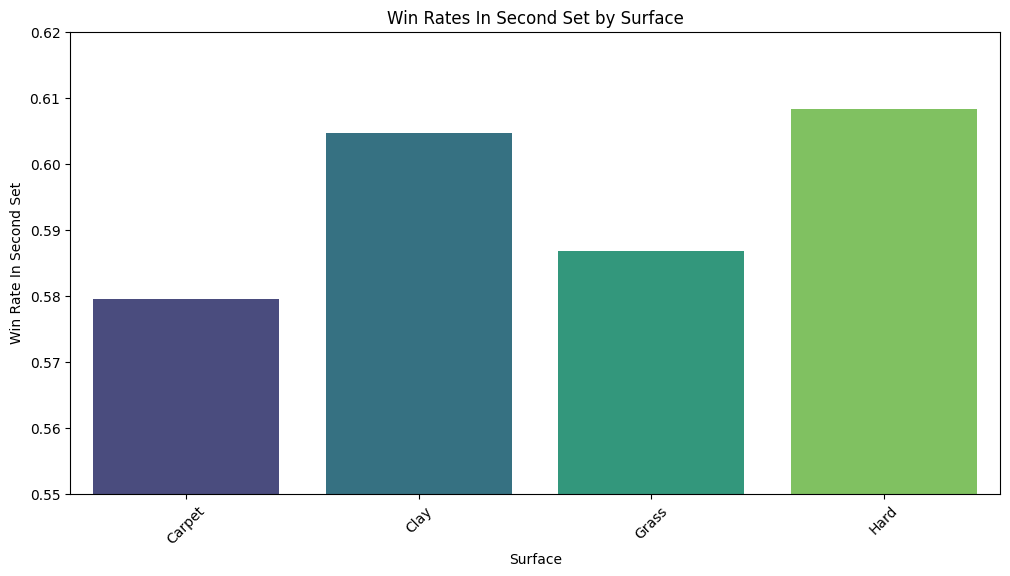

In [7]:
win_rate_summary = df[df['T']==1].groupby('surface')['Y'].mean().reset_index()
win_rate_summary.columns = ['Surface', 'Win Rate In Second Set']

plt.figure(figsize=(12, 6))
sns.barplot(data=win_rate_summary, x='Surface', y='Win Rate In Second Set', palette='viridis')

# Title and labels
plt.title('Win Rates In Second Set by Surface')
plt.xlabel('Surface')
plt.ylabel('Win Rate In Second Set')

# Rotate x labels for better visibility
plt.xticks(rotation=45)
plt.ylim(0.55, 0.62)
plt.show()

# Winner Rank vs Loser Rank

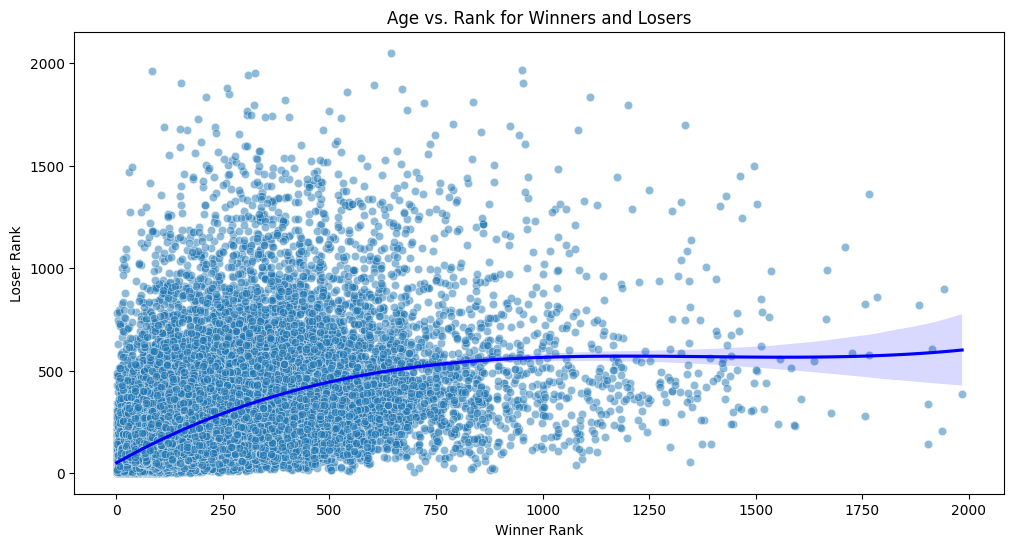

In [8]:
# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='winner_rank', y='loser_rank', alpha=0.5)

# Add regression lines for winners and losers
sns.regplot(data=df, x='winner_rank', y='loser_rank', color='blue', scatter=False, ci=95, order=3)

# Title and labels
plt.title('Age vs. Rank for Winners and Losers')
plt.xlabel('Winner Rank')
plt.ylabel('Loser Rank')

# Show the plot
plt.show()


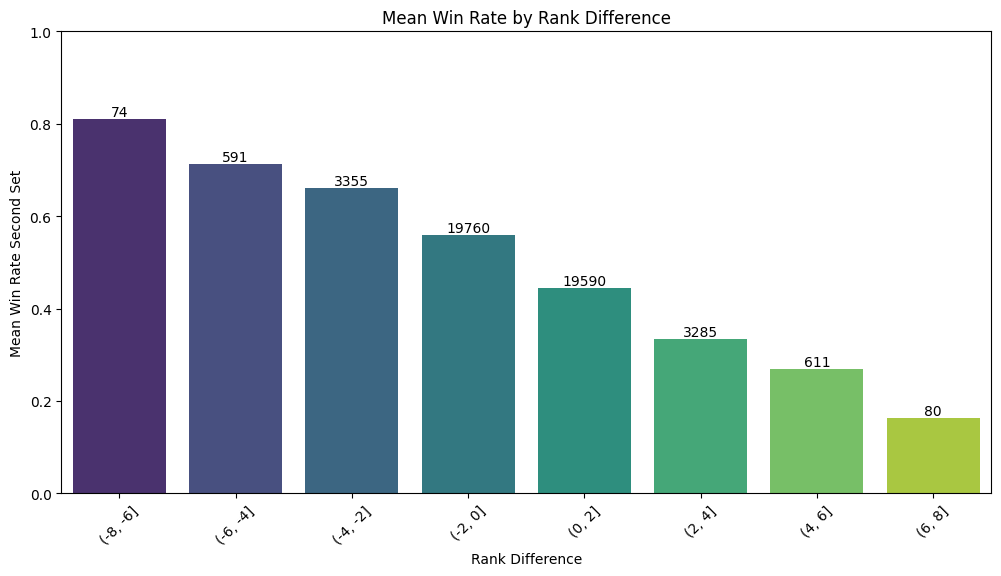

In [9]:
# Bin the rank differences
bins = range(int(df['log_rank_difference'].min()), int(df['log_rank_difference'].max()) + 1, 2)  # Adjust bins as necessary
df['rank_diff_bin'] = pd.cut(df['log_rank_difference'], bins)

# Calculate mean win rates and counts for each bin
mean_win_rate_by_rank_diff = df.groupby('rank_diff_bin')['Y'].mean().reset_index()
count_by_rank_diff = df['rank_diff_bin'].value_counts().reset_index(name='Count')

# Merge mean win rates with counts
mean_win_rate_by_rank_diff = mean_win_rate_by_rank_diff.merge(count_by_rank_diff, on='rank_diff_bin')

# Create a bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=mean_win_rate_by_rank_diff, x='rank_diff_bin', y='Y', palette='viridis')

# Title and labels
plt.title('Mean Win Rate by Rank Difference')
plt.xlabel('Rank Difference')
plt.ylabel('Mean Win Rate Second Set')

# Improve x-ticks for readability
plt.xticks(rotation=45, ha='center')
plt.ylim(0, 1)

# Annotate bars with counts
for index, p in enumerate(bar_plot.patches):
    count = mean_win_rate_by_rank_diff['Count'].iloc[index]
    bar_plot.annotate(f'{count}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', color='black', fontsize=10)
# plt.ylim(0.35,0.6)
# Show the plot
plt.show()


# Best of

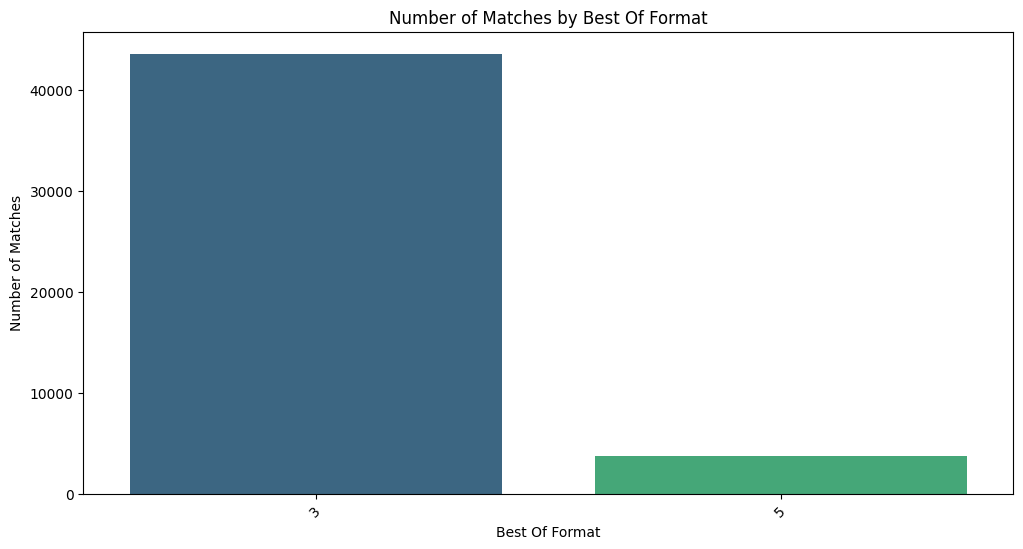

In [10]:
best_of_df = df['best_of'].value_counts().reset_index()
best_of_df.columns = ['Best Of', 'Count']

# Create a bar plot for best_of counts
plt.figure(figsize=(12, 6))
sns.barplot(data=best_of_df, x='Best Of', y='Count', palette='viridis')

# Title and labels
plt.title('Number of Matches by Best Of Format')
plt.xlabel('Best Of Format')
plt.ylabel('Number of Matches')

# Rotate x labels for better visibility if necessary
plt.xticks(rotation=45)

# Show the plot
plt.show()
